# Prediction analysis on train and test data

This notebook serves the purpose to analyse what is going on under the hood. It seems that for C_1 and C_5 we reach an AUC of 1, but for C_2 we reach and AUC of 0.6. Using the averaged center cv classifiers we reach an AUC of 0.97. Looking at the validation AUCs it seems that every classifier is not generalising well.

In [6]:
from pathlib import Path
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, auc, RocCurveDisplay, roc_curve

In [2]:
import sys
sys.path.append('..')

import training_functions as trfs

In [3]:
data_path=Path("../storage/")
(
    X_train,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
) = trfs.load_mocov_train_data(data_path=data_path, tile_averaging=False)

In [4]:
centers_agg = [
            np.unique(centers_train[samples_train == sample])
            for sample in np.unique(samples_train)
        ]
centers_agg = np.array(centers_agg).flatten()

In [5]:
y_agg = [
            np.unique(y_train[samples_train == sample])
            for sample in np.unique(samples_train)
        ]
y_agg = np.array(y_agg).flatten()

In [4]:
estimator = trfs.get_tabular_estimator("LogReg")
lrs_log = trfs.train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    agg_by="mean",
    tile_avg=False,
    subsampling=False,
)

/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC on split 0 validation center C_1: Train - 1.000, Val - 0.572


/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC on split 0 validation center C_5: Train - 0.997, Val - 0.643


/Users/mariastoelben/opt/anaconda3/envs/PythonforDataScience/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC on split 0 validation center C_2: Train - 0.993, Val - 0.609
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.608 (0.029)


In [5]:
preds_log = 0
# loop over the classifiers
for lr in lrs_log:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_log += temp

# and take the average (ensembling technique)
preds_log = preds_log / len(lrs_log)

In [7]:
preds_log

array([0.35867959, 0.54480139, 0.19529433, 0.24963797, 0.58156655,
       0.17176457, 0.44848845, 0.199608  , 0.25966448, 0.37451246,
       0.41893692, 0.32207467, 0.2500688 , 0.59869478, 0.59064549,
       0.28557883, 0.19996015, 0.56149701, 0.45604209, 0.46973288,
       0.37511399, 0.14414791, 0.61930751, 0.31036539, 0.31195839,
       0.34522212, 0.54197783, 0.11059749, 0.46131207, 0.37333411,
       0.25846959, 0.53841055, 0.10695842, 0.18982748, 0.53387379,
       0.4706037 , 0.41736303, 0.15471435, 0.2168136 , 0.14370619,
       0.15179489, 0.21778416, 0.29844478, 0.13693677, 0.23123385,
       0.51107778, 0.75221467, 0.5822238 , 0.31969389, 0.15517186,
       0.41704057, 0.47213614, 0.57671808, 0.62944998, 0.42714439,
       0.25002052, 0.71644878, 0.24831962, 0.7295092 , 0.58151329,
       0.71371795, 0.43143424, 0.15715052, 0.20361605, 0.63520839,
       0.17939856, 0.26350692, 0.61952097, 0.25678053, 0.23744466,
       0.62194382, 0.41488945, 0.23003339, 0.32970902, 0.16248

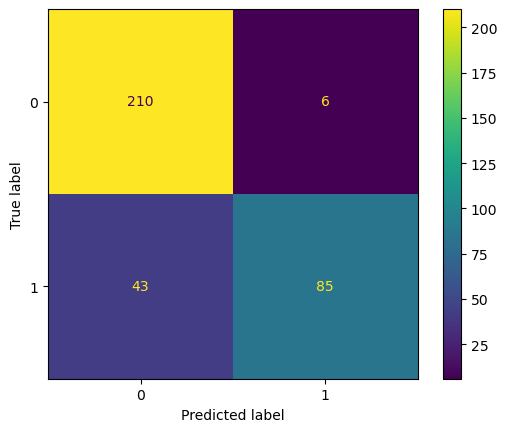

In [8]:
cm = confusion_matrix(y_agg, preds_log > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

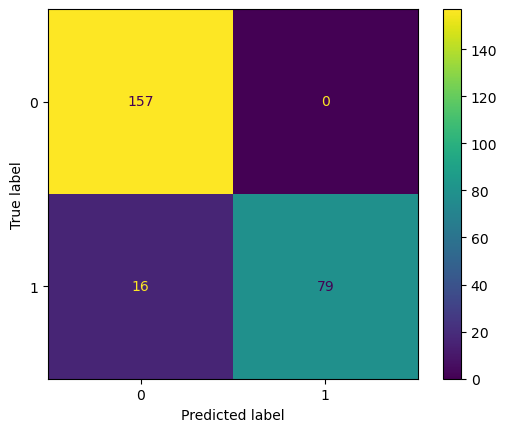

In [51]:
cm = confusion_matrix(y_agg[centers_agg != "C_2"], preds_log[centers_agg != "C_2"] > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [6]:
estimator = trfs.get_tabular_estimator("RF")
lrs_rf = trfs.train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    agg_by="mean",
    tile_avg=False,
    subsampling=False,
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.636
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.637
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.613
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.629 (0.011)


In [18]:
preds_rf = 0
# loop over the classifiers
for lr in lrs_rf:
    temp = lr.predict_proba(X_train)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_rf += temp

# and take the average (ensembling technique)
preds_rf = preds_rf / len(lrs_rf)

In [19]:
preds_rf

array([0.12777, 0.41896, 0.11587, 0.12875, 0.40752, 0.11008, 0.37756,
       0.11707, 0.11993, 0.37113, 0.38132, 0.13204, 0.11686, 0.80506,
       0.79604, 0.11932, 0.28754, 0.79837, 0.77029, 0.77165, 0.76094,
       0.0914 , 0.41562, 0.36152, 0.12139, 0.14374, 0.79759, 0.0883 ,
       0.40839, 0.14389, 0.34056, 0.78429, 0.09876, 0.1019 , 0.77762,
       0.78425, 0.14513, 0.10086, 0.1147 , 0.0931 , 0.28167, 0.30641,
       0.13681, 0.32515, 0.10455, 0.77753, 0.81409, 0.79737, 0.11888,
       0.10781, 0.77068, 0.76794, 0.78263, 0.81142, 0.41658, 0.12874,
       0.80275, 0.12773, 0.4134 , 0.78741, 0.80809, 0.13005, 0.0924 ,
       0.29994, 0.79671, 0.11556, 0.11869, 0.79949, 0.11278, 0.29313,
       0.79199, 0.373  , 0.13492, 0.11962, 0.10174, 0.11053, 0.36543,
       0.13111, 0.11633, 0.39938, 0.79742, 0.07151, 0.39146, 0.35654,
       0.11204, 0.80288, 0.11746, 0.32075, 0.31866, 0.7813 , 0.8014 ,
       0.41372, 0.36095, 0.14156, 0.32812, 0.81756, 0.15578, 0.81599,
       0.12904, 0.31

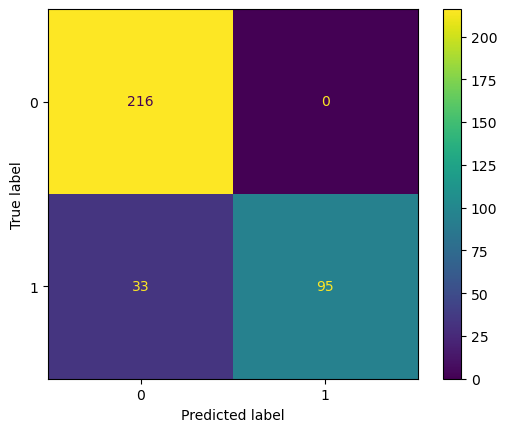

In [21]:
cm = confusion_matrix(y_agg, preds_rf > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [31]:
preds_rf = 0
# loop over the classifiers
for lr in lrs_rf:
    temp_ = lr.predict_proba(X_train)[:, 1]
    temp_ = trfs.pred_aggregation(temp_, samples_train)
    preds_rf += temp_

# and take the average (ensembling technique)
preds_rf = preds_rf / len(lrs_rf)

In [32]:
preds_rf

array([0.13633, 0.44857, 0.11899, 0.1332 , 0.42697, 0.1193 , 0.39608,
       0.11819, 0.12193, 0.39261, 0.40274, 0.13718, 0.12258, 0.80692,
       0.80166, 0.12255, 0.31539, 0.80296, 0.77456, 0.77772, 0.7647 ,
       0.09592, 0.43016, 0.37759, 0.12567, 0.14812, 0.80326, 0.09696,
       0.42513, 0.14815, 0.36842, 0.79239, 0.10309, 0.11   , 0.78319,
       0.78807, 0.15118, 0.10635, 0.11713, 0.10011, 0.31177, 0.33006,
       0.14525, 0.34257, 0.11115, 0.78422, 0.81865, 0.80236, 0.12415,
       0.11261, 0.7773 , 0.77507, 0.78972, 0.81418, 0.43408, 0.13483,
       0.81242, 0.13045, 0.45232, 0.79492, 0.81847, 0.13755, 0.10152,
       0.31809, 0.80074, 0.12589, 0.12807, 0.80332, 0.11921, 0.32316,
       0.80026, 0.4018 , 0.13991, 0.12468, 0.1079 , 0.117  , 0.39491,
       0.13622, 0.12145, 0.42337, 0.79997, 0.08087, 0.4197 , 0.38057,
       0.11851, 0.81099, 0.12078, 0.34186, 0.35079, 0.78678, 0.80715,
       0.43886, 0.37715, 0.1446 , 0.35921, 0.82521, 0.16028, 0.82321,
       0.13081, 0.33

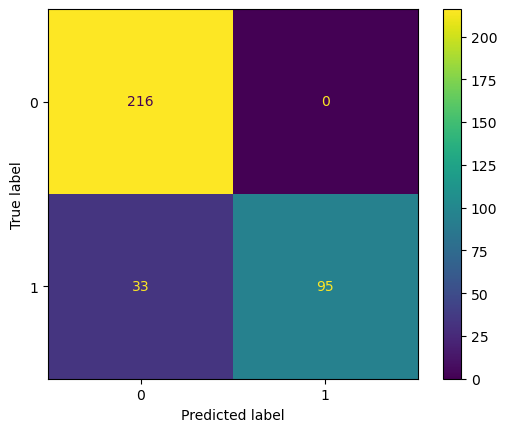

In [33]:
cm = confusion_matrix(y_agg, preds_rf > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

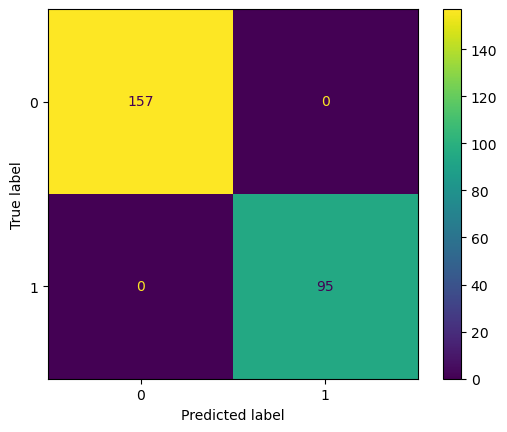

In [89]:
cm = confusion_matrix(y_agg[centers_agg != "C_2"], preds_rf[centers_agg != "C_2"] > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [10]:
y_agg[centers_agg == "C_2"]

array([1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1.])

In [23]:
preds_rf[centers_agg == "C_2"]

array([0.41896, 0.40752, 0.37756, 0.37113, 0.38132, 0.28754, 0.41562,
       0.36152, 0.40839, 0.34056, 0.28167, 0.30641, 0.32515, 0.41658,
       0.4134 , 0.29994, 0.29313, 0.373  , 0.36543, 0.39938, 0.39146,
       0.35654, 0.32075, 0.31866, 0.41372, 0.36095, 0.32812, 0.31973,
       0.36987, 0.39347, 0.34471, 0.34538, 0.3896 , 0.31583, 0.42767,
       0.32722, 0.38558, 0.36202, 0.29494, 0.34153, 0.37372, 0.42652,
       0.39439, 0.30459, 0.37048, 0.40635, 0.32863, 0.34825, 0.32109,
       0.32296, 0.31965, 0.28647, 0.30669, 0.26896, 0.31465, 0.37938,
       0.44565, 0.31137, 0.37264, 0.32593, 0.37559, 0.42048, 0.25505,
       0.32158, 0.43872, 0.27335, 0.33378, 0.35037, 0.30008, 0.34333,
       0.3135 , 0.32966, 0.36009, 0.32543, 0.33967, 0.35456, 0.34895,
       0.35824, 0.33784, 0.37521, 0.34377, 0.43098, 0.35884, 0.32394,
       0.33873, 0.34032, 0.28568, 0.33413, 0.311  , 0.33529, 0.47409,
       0.33464])

In [59]:
np.unique(samples_train)[centers_agg == "C_2"]

array(['ID_002.npy', 'ID_007.npy', 'ID_013.npy', 'ID_018.npy',
       'ID_019.npy', 'ID_026.npy', 'ID_037.npy', 'ID_039.npy',
       'ID_046.npy', 'ID_049.npy', 'ID_061.npy', 'ID_062.npy',
       'ID_064.npy', 'ID_080.npy', 'ID_084.npy', 'ID_090.npy',
       'ID_096.npy', 'ID_098.npy', 'ID_106.npy', 'ID_110.npy',
       'ID_113.npy', 'ID_114.npy', 'ID_118.npy', 'ID_120.npy',
       'ID_124.npy', 'ID_126.npy', 'ID_129.npy', 'ID_138.npy',
       'ID_139.npy', 'ID_150.npy', 'ID_151.npy', 'ID_153.npy',
       'ID_154.npy', 'ID_160.npy', 'ID_172.npy', 'ID_174.npy',
       'ID_176.npy', 'ID_180.npy', 'ID_184.npy', 'ID_190.npy',
       'ID_204.npy', 'ID_205.npy', 'ID_209.npy', 'ID_213.npy',
       'ID_220.npy', 'ID_221.npy', 'ID_226.npy', 'ID_227.npy',
       'ID_229.npy', 'ID_235.npy', 'ID_237.npy', 'ID_242.npy',
       'ID_245.npy', 'ID_249.npy', 'ID_258.npy', 'ID_264.npy',
       'ID_268.npy', 'ID_286.npy', 'ID_288.npy', 'ID_289.npy',
       'ID_301.npy', 'ID_307.npy', 'ID_309.npy', 'ID_32

In [29]:
roc_auc_score(y_agg[centers_agg == "C_5"], preds_rf[centers_agg == "C_5"])

1.0

In [32]:
fpr, tpr, thresholds = roc_curve(y_agg[centers_agg == "C_2"], preds_rf[centers_agg == "C_2"])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')

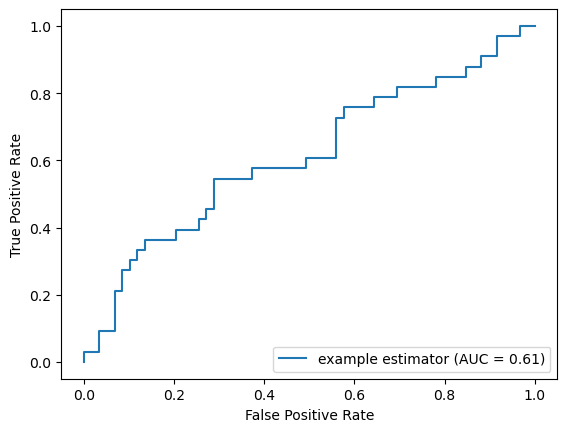

In [33]:
display.plot()

In [72]:
import matplotlib.pyplot as plt

In [81]:
np.max(X_train[centers_train == "C_2"])

6.038034915924072

In [80]:
np.max(X_train[centers_train != "C_2"])

5.32080078125

(array([1.700063e+08, 9.989573e+06, 3.904634e+06, 1.882486e+06,
        1.016143e+06, 5.879740e+05, 3.574480e+05, 2.235540e+05,
        1.450470e+05, 9.675400e+04, 6.628500e+04, 4.559600e+04,
        3.085700e+04, 2.138600e+04, 1.406000e+04, 9.123000e+03,
        6.070000e+03, 4.120000e+03, 2.698000e+03, 1.849000e+03,
        1.286000e+03, 9.260000e+02, 5.780000e+02, 4.300000e+02,
        2.550000e+02, 1.800000e+02, 1.380000e+02, 7.500000e+01,
        5.000000e+01, 4.500000e+01, 1.700000e+01, 1.500000e+01,
        1.100000e+01, 8.000000e+00, 6.000000e+00, 3.000000e+00,
        2.000000e+00, 2.000000e+00, 1.000000e+00, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 2.000000e+00,
        2.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
        2.000000e+00, 1.000000e+00]),
 array([0.        , 0.1207607 , 0.2415214 , 0.36228209, 0.48304279,
        0.60380349, 0.72456419, 0.84532489, 0.96608559, 1.08684628,
        1.20760698, 1.32836768, 1.44912838, 1.56988908, 1.

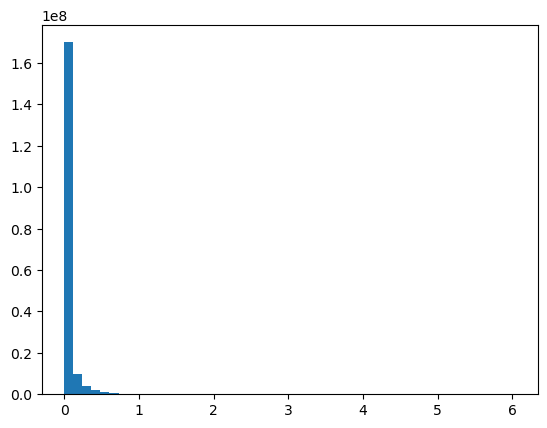

In [82]:
plt.hist(X_train[centers_train == "C_2"].flatten(), bins=50)

(array([1.700063e+08, 9.989573e+06, 3.904634e+06, 1.882486e+06,
        1.016143e+06, 5.879740e+05, 3.574480e+05, 2.235540e+05,
        1.450470e+05, 9.675400e+04, 6.628500e+04, 4.559600e+04,
        3.085700e+04, 2.138600e+04, 1.406000e+04, 9.123000e+03,
        6.070000e+03, 4.120000e+03, 2.698000e+03, 1.849000e+03,
        1.286000e+03, 9.260000e+02, 5.780000e+02, 4.300000e+02,
        2.550000e+02, 1.800000e+02, 1.380000e+02, 7.500000e+01,
        5.000000e+01, 4.500000e+01, 1.700000e+01, 1.500000e+01,
        1.100000e+01, 8.000000e+00, 6.000000e+00, 3.000000e+00,
        2.000000e+00, 2.000000e+00, 1.000000e+00, 2.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 2.000000e+00,
        2.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
        2.000000e+00, 1.000000e+00]),
 array([0.        , 0.1207607 , 0.2415214 , 0.36228209, 0.48304279,
        0.60380349, 0.72456419, 0.84532489, 0.96608559, 1.08684628,
        1.20760698, 1.32836768, 1.44912838, 1.56988908, 1.

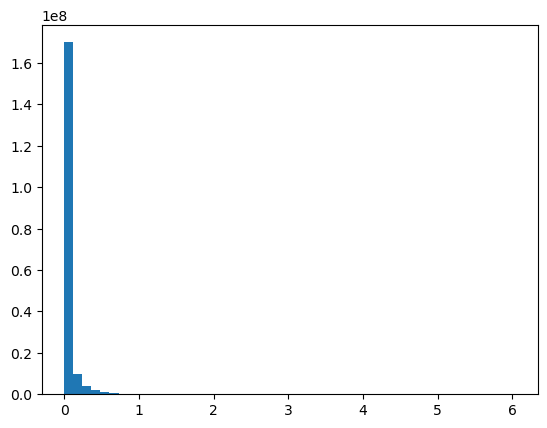

In [83]:
plt.hist(X_train[centers_train == "C_2"].flatten(), bins=50)

In [27]:
preds_c1_c2 = lrs_rf[1].predict_proba(X_train)[:, 1]
preds_c1_c2 = trfs.pred_aggregation(preds_c1_c2, samples_train, "mean_25")

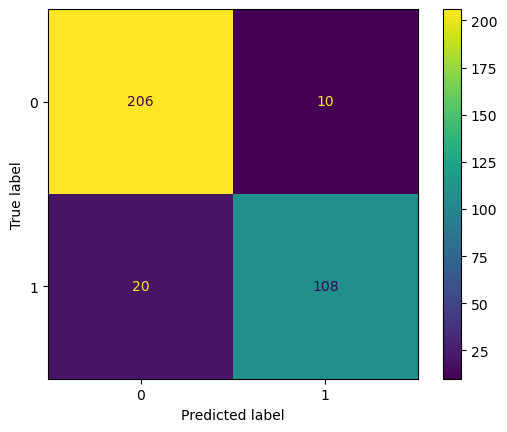

In [28]:
cm = confusion_matrix(y_agg, preds_c1_c2 > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [29]:
preds_c1_c2

array([0.18972, 0.53644, 0.17852, 0.1916 , 0.51704, 0.16444, 0.48344,
       0.1702 , 0.17136, 0.4836 , 0.48632, 0.2024 , 0.17388, 0.8658 ,
       0.85788, 0.17904, 0.39008, 0.86284, 0.83092, 0.83496, 0.8302 ,
       0.14468, 0.53204, 0.45696, 0.17556, 0.20164, 0.86176, 0.14448,
       0.52248, 0.20624, 0.46968, 0.85324, 0.16076, 0.15728, 0.83784,
       0.84924, 0.20764, 0.16236, 0.16992, 0.15052, 0.41536, 0.40728,
       0.19856, 0.43268, 0.15692, 0.85016, 0.87252, 0.857  , 0.17904,
       0.17084, 0.83568, 0.83816, 0.84444, 0.86968, 0.53552, 0.20004,
       0.8746 , 0.19084, 0.55048, 0.85616, 0.87388, 0.18872, 0.15264,
       0.40424, 0.85708, 0.18144, 0.18084, 0.86248, 0.16656, 0.40184,
       0.86176, 0.48652, 0.19836, 0.17132, 0.15348, 0.18524, 0.48272,
       0.19512, 0.17056, 0.51416, 0.85836, 0.13072, 0.5148 , 0.48544,
       0.16688, 0.8632 , 0.18056, 0.4476 , 0.42752, 0.84916, 0.86232,
       0.5208 , 0.46616, 0.19952, 0.44296, 0.88036, 0.21356, 0.88036,
       0.184  , 0.41

In [13]:
X_test, _, _, samples_test = trfs.load_mocov_test_data(data_path=data_path, tile_averaging=False)

In [14]:
preds_test_rf = 0
# loop over the classifiers
for lr in lrs_rf[1]:
    temp = lr.predict_proba(X_test)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_test)
    preds_test_rf += temp

# and take the average (ensembling technique)
preds_test_rf = preds_test_rf / len(lrs_rf)

In [15]:
preds_test_rf

array([0.42681, 0.43331, 0.41044, 0.39459, 0.3822 , 0.44525, 0.32808,
       0.4629 , 0.41758, 0.37387, 0.40143, 0.42716, 0.40299, 0.4024 ,
       0.41346, 0.40397, 0.39545, 0.42455, 0.41951, 0.45534, 0.44258,
       0.40635, 0.38312, 0.42636, 0.47227, 0.45011, 0.45919, 0.4004 ,
       0.45874, 0.44005, 0.38679, 0.43987, 0.40916, 0.43139, 0.40918,
       0.45586, 0.41602, 0.32865, 0.40595, 0.41999, 0.42295, 0.40772,
       0.38997, 0.37306, 0.34815, 0.35706, 0.38872, 0.45127, 0.37635,
       0.38863, 0.43718, 0.43497, 0.41453, 0.41812, 0.46918, 0.42798,
       0.44499, 0.42596, 0.41523, 0.37707, 0.46335, 0.4066 , 0.39114,
       0.43058, 0.44   , 0.38759, 0.39214, 0.44648, 0.42182, 0.43233,
       0.40516, 0.44745, 0.40212, 0.45049, 0.41152, 0.38658, 0.40764,
       0.42523, 0.44389, 0.39969, 0.4426 , 0.45447, 0.41842, 0.42014,
       0.41359, 0.39711, 0.4386 , 0.42099, 0.47119, 0.45505, 0.38467,
       0.45191, 0.41768, 0.46042, 0.34102, 0.47198, 0.41537, 0.44037,
       0.41793, 0.42

In [16]:
preds_test_log = 0
# loop over the classifiers
for lr in lrs_log:
    temp = lr.predict_proba(X_test)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_test)
    preds_test_log += temp

# and take the average (ensembling technique)
preds_test_log = preds_test_log / len(lrs_rf)

In [17]:
preds_test_log

array([0.36281314, 0.43611364, 0.11246348, 0.15196188, 0.25686479,
       0.55012678, 0.21980187, 0.13182645, 0.15240981, 0.27677939,
       0.31679578, 0.47769713, 0.24510159, 0.31643288, 0.17005777,
       0.46334199, 0.43105343, 0.34437435, 0.24018544, 0.34502344,
       0.15699355, 0.0914849 , 0.28476429, 0.3681663 , 0.33343485,
       0.19844309, 0.68696427, 0.29801671, 0.11267948, 0.36397226,
       0.16459175, 0.38684487, 0.38309683, 0.43592439, 0.4346609 ,
       0.2931529 , 0.12897563, 0.16527815, 0.10398579, 0.45241452,
       0.08546659, 0.25432325, 0.38084288, 0.43243093, 0.26033849,
       0.25088036, 0.20864713, 0.28268316, 0.31415273, 0.42270337,
       0.54854492, 0.15537266, 0.24507737, 0.54526763, 0.58926403,
       0.49655408, 0.20641271, 0.05494983, 0.43619774, 0.24406835,
       0.24443036, 0.23414964, 0.34489668, 0.54470318, 0.29202285,
       0.38489642, 0.49018977, 0.5261083 , 0.19452496, 0.5496236 ,
       0.35569364, 0.5495472 , 0.32843359, 0.35331309, 0.09029

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(X_scaled)

PCA(n_components=50)

In [20]:
print(pca.explained_variance_ratio_)

[0.04742969 0.03268537 0.02661569 0.02513273 0.02095062 0.01942504
 0.01625628 0.01421645 0.01338424 0.01324946 0.01185965 0.01139824
 0.01017145 0.00987684 0.00880216 0.00853812 0.00796318 0.00789978
 0.00733101 0.00706129 0.00659091 0.00651307 0.0064221  0.00621356
 0.00599324 0.00583518 0.00568127 0.00526514 0.00517483 0.00514884
 0.00497553 0.00489021 0.00476209 0.00460929 0.00443901 0.0043898
 0.00426101 0.00419162 0.0041176  0.00396776 0.00379649 0.00374188
 0.00368724 0.00361999 0.00346024 0.00342616 0.00338166 0.00323423
 0.00315436 0.00311857]


In [21]:
X_PCA = pca.transform(X_train)

In [22]:
estimator = trfs.get_tabular_estimator("RF")
lrs_rf_PCA = trfs.train_mocov_features(
    estimator,
    X_PCA,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    agg_by="mean",
    tile_avg=False,
    subsampling=False,
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.623
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.610
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.600
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.611 (0.009)


In [23]:
preds_rf = 0
# loop over the classifiers
for lr in lrs_rf_PCA:
    temp = lr.predict_proba(X_PCA)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_rf += temp

# and take the average (ensembling technique)
preds_rf = preds_rf / len(lrs_rf_PCA)

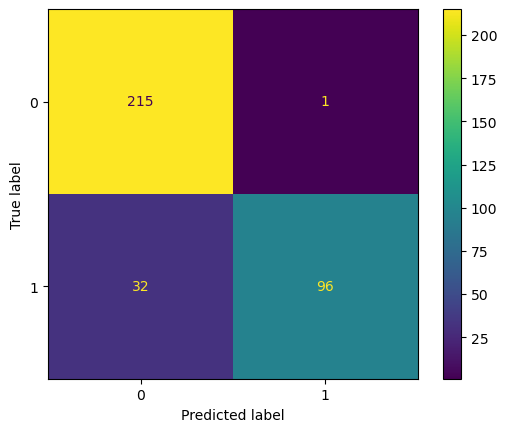

In [24]:
cm = confusion_matrix(y_agg, preds_rf > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [25]:
estimator = trfs.get_tabular_estimator("LogReg")
lrs_lr_PCA = trfs.train_mocov_features(
    estimator,
    X_PCA,
    y_train,
    patients_unique,
    y_unique,
    patients_train,
    samples_train,
    centers_train,
    agg_by="mean",
    tile_avg=False,
    subsampling=False,
)

AUC on split 0 validation center C_1: Train - 0.824, Val - 0.621
AUC on split 0 validation center C_5: Train - 0.799, Val - 0.631
AUC on split 0 validation center C_2: Train - 0.807, Val - 0.609
----------------------------
5-fold cross-validated AUC averaged over 1 repeats: 0.620 (0.009)


In [26]:
preds_log = 0
# loop over the classifiers
for lr in lrs_lr_PCA:
    temp = lr.predict_proba(X_PCA)[:, 1]
    temp = trfs.pred_aggregation(temp, samples_train)
    preds_log += temp

# and take the average (ensembling technique)
preds_log = preds_log / len(lrs_lr_PCA)

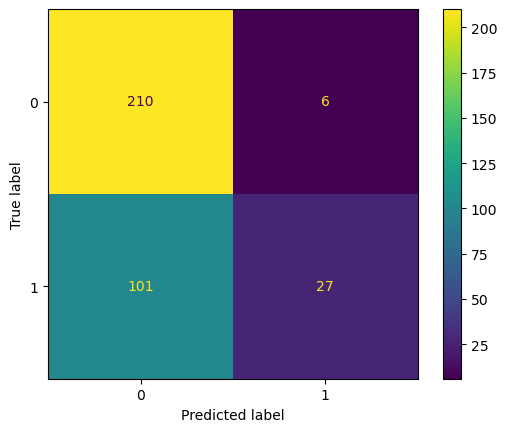

In [27]:
cm = confusion_matrix(y_agg, preds_log > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Creating classifiers with training samples of only one center

In [12]:
estimator_C_2 = trfs.get_tabular_estimator("RF")
estimator_C_2.fit(X_train[centers_train == "C_2"], y_train[centers_train == "C_2"])

RandomForestClassifier(n_jobs=6)

In [14]:
preds_train_c_2 = estimator_C_2.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_train_c_2 = trfs.pred_aggregation(preds_train_c_2, samples_train[centers_train == "C_2"])

preds_val_2_1 = estimator_C_2.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_val_2_1 = trfs.pred_aggregation(preds_val_2_1, samples_train[centers_train == "C_1"])

preds_val_2_5 = estimator_C_2.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_val_2_5 = trfs.pred_aggregation(preds_val_2_5, samples_train[centers_train == "C_5"])

In [15]:
print("Train AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_train_c_2))
print("Val AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_val_2_1))
print("Val AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_val_2_5))

Train AUC C_2:  1.0
Val AUC C_1:  0.596881449208897
Val AUC C_5:  0.6032608695652174


In [16]:
estimator_C_1 = trfs.get_tabular_estimator("RF")
estimator_C_1.fit(X_train[centers_train == "C_1"], y_train[centers_train == "C_1"])

RandomForestClassifier(n_jobs=6)

In [17]:
preds_train_c_1 = estimator_C_1.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_train_c_1 = trfs.pred_aggregation(preds_train_c_1, samples_train[centers_train == "C_1"])

preds_val_1_2 = estimator_C_1.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_val_1_2 = trfs.pred_aggregation(preds_val_1_2, samples_train[centers_train == "C_2"])

preds_val_1_5 = estimator_C_1.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_val_1_5 = trfs.pred_aggregation(preds_val_1_5, samples_train[centers_train == "C_5"])

In [18]:
print("Train AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_train_c_1))
print("Val AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_val_1_2))
print("Val AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_val_1_5))

Train AUC C_1:  1.0
Val AUC C_2:  0.5798664612223934
Val AUC C_5:  0.6508951406649616


In [19]:
estimator_C_5 = trfs.get_tabular_estimator("RF")
estimator_C_5.fit(X_train[centers_train == "C_5"], y_train[centers_train == "C_5"])

RandomForestClassifier(n_jobs=6)

In [21]:
preds_train_c_5 = estimator_C_5.predict_proba(X_train[centers_train == "C_5"])[:, 1]
preds_train_c_5 = trfs.pred_aggregation(preds_train_c_5, samples_train[centers_train == "C_5"])

preds_val_5_1 = estimator_C_5.predict_proba(X_train[centers_train == "C_1"])[:, 1]
preds_val_5_1 = trfs.pred_aggregation(preds_val_5_1, samples_train[centers_train == "C_1"])

preds_val_5_2 = estimator_C_5.predict_proba(X_train[centers_train == "C_2"])[:, 1]
preds_val_5_2 = trfs.pred_aggregation(preds_val_5_2, samples_train[centers_train == "C_2"])

In [22]:
print("Train AUC C_5: ", roc_auc_score(y_agg[centers_agg == "C_5"], preds_train_c_5))
print("Val AUC C_1: ", roc_auc_score(y_agg[centers_agg == "C_1"], preds_val_5_1))
print("Val AUC C_2: ", roc_auc_score(y_agg[centers_agg == "C_2"], preds_val_5_2))

Train AUC C_5:  1.0
Val AUC C_1:  0.6230222426049071
Val AUC C_2:  0.5973292244478685
